In [1]:
!pip install pmdarima
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\zisha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
df = pd.read_csv('wptw.csv')

C:\Users\zisha\AppData\Local\Temp\ipykernel_38456\1643196432.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('wptw.csv')


In [3]:
df.head()

,STORE,UPC,WEEK,MOVE,PRICE,QTY,SALE,PROFIT,OK,PRICE_HEX,PROFIT_HEX
0,2,1122542322,336,0,0.00,1,NaN,0.00,1,0000000000000000,0000000000000000
1,2,1122542322,337,4,1.59,1,NaN,6.60,1,3FF970A3D70A3D71,401A666666666666
2,2,1122542322,338,22,1.59,1,NaN,6.60,1,3FF970A3D70A3D71,401A666666666666
3,2,1122542322,339,36,1.59,1,NaN,6.60,1,3FF970A3D70A3D71,401A666666666666
4,2,1122542322,344,29,1.79,1,NaN,22.78,1,3FFCA3D70A3D70A4,4036C7AE147AE148


In [4]:
df.tail()

,STORE,UPC,WEEK,MOVE,PRICE,QTY,SALE,PROFIT,OK,PRICE_HEX,PROFIT_HEX
1847012,139,7572536605,395,0,0.0,1,NaN,0.0,1,0000000000000000,0000000000000000
1847013,139,7572536605,396,0,0.0,1,NaN,0.0,1,0000000000000000,0000000000000000
1847014,139,7572536605,397,0,0.0,1,NaN,0.0,1,0000000000000000,0000000000000000
1847015,139,7572536605,398,0,0.0,1,NaN,0.0,1,0000000000000000,0000000000000000
1847016,139,7572536605,399,0,0.0,1,NaN,0.0,1,0000000000000000,0000000000000000


In [5]:
df.shape

(1847017, 11)

In [6]:
selected_df = df[(df['UPC'] == 3700063527) & (df['STORE'] == 112)][['WEEK', 'MOVE']]

In [7]:
selected_df.head()

,WEEK,MOVE
420551,1,85
420552,2,89
420553,3,98
420554,4,75
420555,5,114


In [8]:
selected_df.tail()

,WEEK,MOVE
420935,395,70
420936,396,50
420937,397,44
420938,398,59
420939,399,56


In [9]:
print(selected_df.shape)

(389, 2)


In [10]:
# Remove any noise
selected_df['MOVE'] = selected_df['MOVE'][(selected_df['MOVE'] - selected_df['MOVE'].mean()).abs() < 3 * selected_df['MOVE'].std()]
selected_df = selected_df.dropna()

In [11]:
print(selected_df.shape)

(387, 2)


In [12]:
# Add missing weeks
max_week = selected_df['WEEK'].max()
all_weeks = range(1, max_week + 1)
missing_weeks = set(all_weeks) - set(selected_df['WEEK'])
missing_data = [{'WEEK': week, 'MOVE': selected_df['MOVE'].mean()} for week in missing_weeks]
missing_df = pd.DataFrame(missing_data)
selected_df = pd.concat([selected_df, missing_df]).sort_values('WEEK').reset_index(drop=True)
selected_df['MOVE'] = selected_df['MOVE'].fillna(selected_df['MOVE'].mean())

In [13]:
print(selected_df.shape)

(399, 2)


In [14]:
selected_df.head()

,WEEK,MOVE
0,1,85.0
1,2,89.0
2,3,98.0
3,4,75.0
4,5,114.0


In [15]:
selected_df.describe()

,WEEK,MOVE
count,399.000000,399.000000
mean,200.000000,60.152455
std,115.325626,20.802373
min,1.000000,0.000000
25%,100.500000,46.000000
50%,200.000000,57.000000
75%,299.500000,73.000000
max,399.000000,131.000000


In [16]:
selected_df.set_index('WEEK', inplace=True)

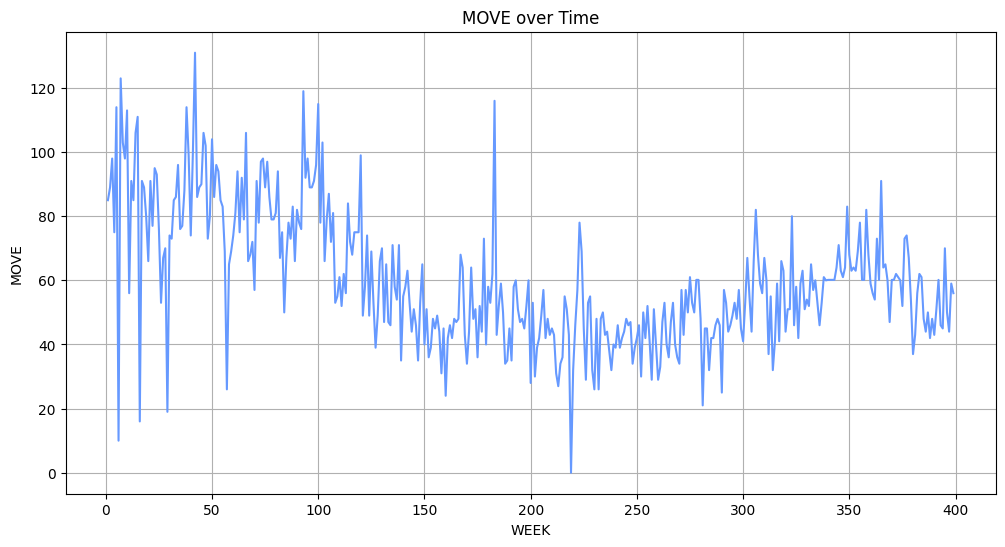

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(selected_df, color = '#6699ff')
plt.title('MOVE over Time')
plt.xlabel('WEEK')
plt.ylabel('MOVE')
plt.grid(True)
plt.show()

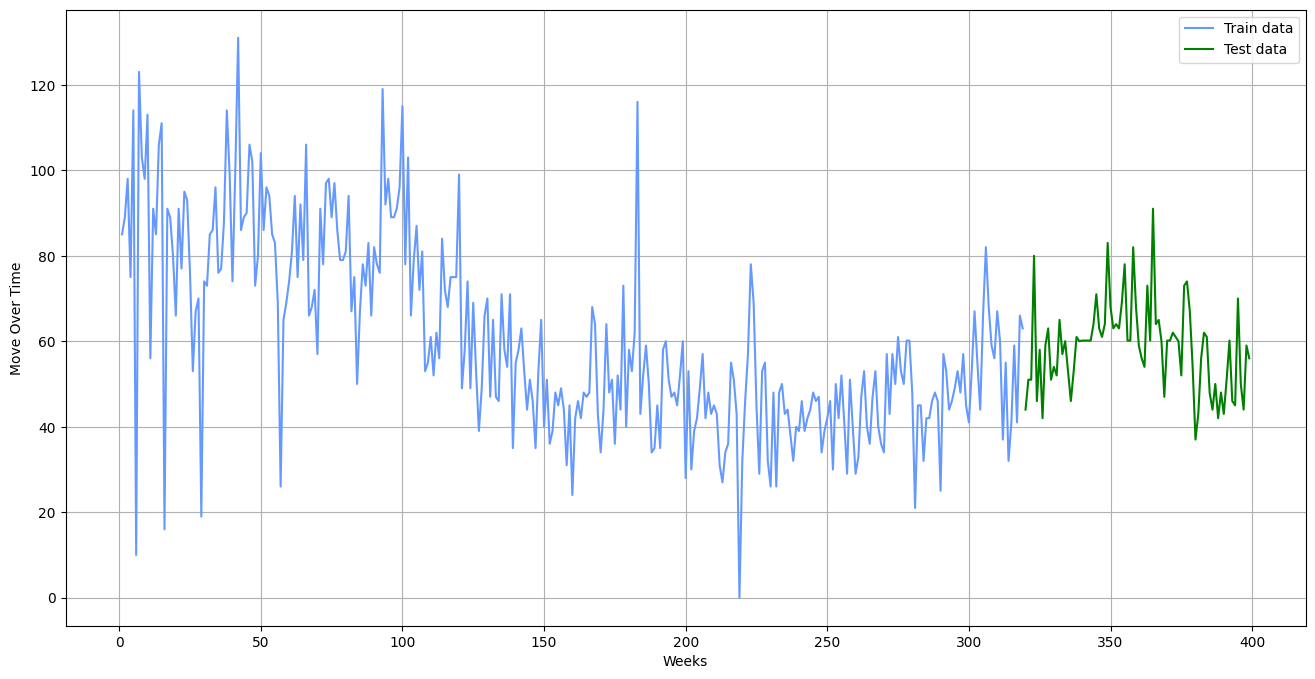

In [18]:
train_data, test_data = selected_df[0:int(len(selected_df)*0.8)], selected_df[int(len(selected_df)*0.8):]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Weeks')
plt.ylabel('Move Over Time')
plt.plot(train_data['MOVE'],'#6699ff', label='Train data')
plt.plot(test_data['MOVE'], 'green', label='Test data')
plt.legend()

In [19]:
from statsmodels.tsa.arima.model import ARIMA

train_arima = train_data['MOVE']
test_arima = test_data['MOVE']

history = [x for x in train_arima]
y = [z for z in test_arima]

# make first prediction
predictions = list()
model = ARIMA(history, order=(0,1,1))
model_fit = model.fit()
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
    

In [20]:
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)

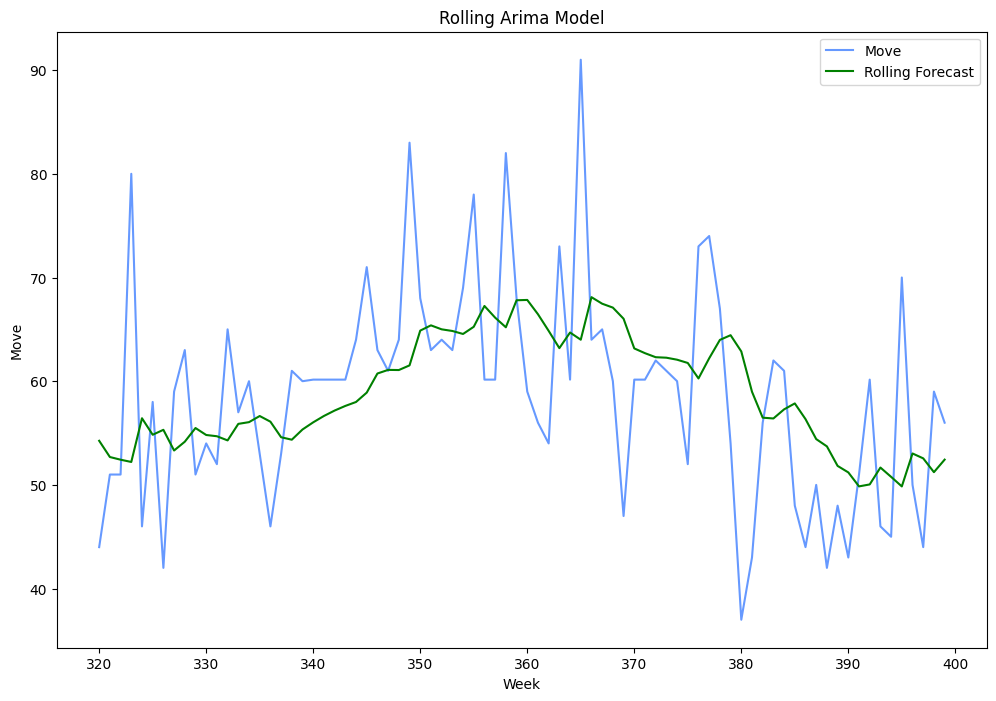

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(test_data.index, y, color = '#6699ff', label = 'Move')
plt.plot(test_data.index, predictions, color = 'green', label = 'Rolling Forecast')
plt.title('Rolling Arima Model')
plt.xlabel('Week')
plt.ylabel('Move')
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
# report performance
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))

MSE: 90.18997691016477
MAE: 7.194102866931689
RMSE: 9.496840364572039
